### Comparison of `Vanilla XGBoost`, `Random-Search Tuned XGBoost` and `Self-Pace-Ensemble boosted XGBoost`

In [1]:
RANDOM_STATE = 42

In [41]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from scipy.stats import mannwhitneyu

from xgboost import XGBClassifier
from imbens.ensemble import SelfPacedEnsembleClassifier as SPEClassifier

import warnings
warnings.filterwarnings('ignore')

### Preparation

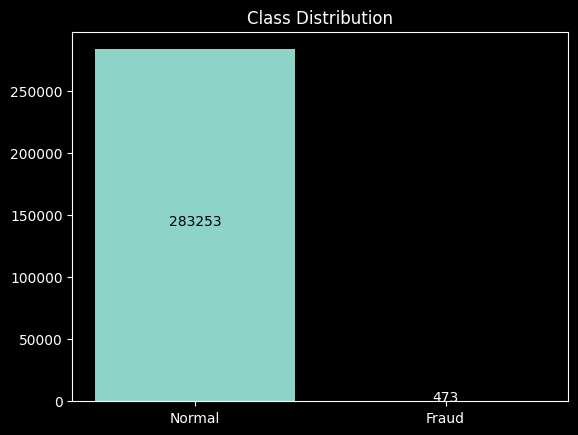

In [23]:
# Importing the dataset
path_to_data = '../data/creditcard/creditcard.csv'

# col names data set
col_names = [
    "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","label"
] # V1-V28 are PCA transformed features, but are anonymized due to confidentiality reasons and are not interpretable
# Label is 1 if fraud, 0 otherwise

# read full data set
data = pd.read_csv(path_to_data, names=col_names, index_col=0, header=0)

# drop duplicates  & time column
data.drop_duplicates(inplace=True)
data.drop("Time", axis=1, inplace=True)

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Stratified 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Visualize class imbalance
plt.bar(["Normal", "Fraud"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1])
normal_percentage = (data["label"].value_counts()[0])

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage}', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage}', ha='center', color='white')
plt.title("Class Distribution")
plt.show()

### Define pipelines and search space for RandomizedSearchCV

In [6]:
# Random search parameter space, prefix parameters with 'xgb__'
search_space_random_tuned = {
    'xgb__objective': ['binary:logistic'],
    'xgb__max_leaves': [0, 2**6, 2**8],
    'xgb__learning_rate': [0.002, 0.1, 0.3],
    'xgb__gamma': [0.1, 0.3],
    'xgb__max_depth': [6, 12, 20, 25],
    'xgb__subsample': [0.4, 0.7, 1],
    'xgb__colsample_bytree': [0.4, 0.5, 0.7, 1],
    'xgb__reg_alpha': [0, 0.9, 1],
    'xgb__reg_lambda': [0.3, 1],
    'xgb__eval_metric': ['aucpr'],
    'xgb__scale_pos_weight': [1, 2, 4, 580],
    'xgb__n_estimators': [100, 170, 500, 700, 1000, 2000, 5000],
    'xgb__booster': ['gbtree'],
    'xgb__tree_method': ['hist'],
}

# Vanilla XGBoost
vanilla_xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier())  # Default XGBoost classifier
])

# RandomizedSearchCV XGBoost
random_search_xgb = Pipeline([
    ('xgb', XGBClassifier())
])

# Randomized search
random_search = RandomizedSearchCV(
    estimator=random_search_xgb,
    param_distributions=search_space_random_tuned,
    n_iter=10,
    scoring='f1',  # Use F1-score to handle imbalanced classes
    cv=StratifiedKFold(n_splits=10), # 10-fold stratified cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Self-paced ensemble classifier with XGBoost as base learner
spe_boosted_xgb_pipeline = Pipeline([
    ('spe_xgb', SPEClassifier(
		estimator=XGBClassifier(),
    )) 
])

### RandomSearch Tuning

In [7]:
# Run random search on XGBoost and fit to training data
print("Running RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train)

# Best parameters from random search
best_params = random_search.best_params_
print(f"Best parameters from RandomizedSearchCV: {best_params}")

# Best estimator from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# save model
joblib.dump(best_xgb_model, 'saved/best_xgb_model.pkl')

Running RandomizedSearchCV for XGBoost...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters from RandomizedSearchCV: {'xgb__tree_method': 'hist', 'xgb__subsample': 0.4, 'xgb__scale_pos_weight': 580, 'xgb__reg_lambda': 0.3, 'xgb__reg_alpha': 0.9, 'xgb__objective': 'binary:logistic', 'xgb__n_estimators': 700, 'xgb__max_leaves': 256, 'xgb__max_depth': 20, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__eval_metric': 'aucpr', 'xgb__colsample_bytree': 1, 'xgb__booster': 'gbtree'}


In [15]:
models = [
    ('Vanilla XGBoost', vanilla_xgb_pipeline),
    ('RandomizedSearchCV XGBoost', best_xgb_model),
    ('SPE-Boosted XGBoost', spe_boosted_xgb_pipeline)
]

# Define custom scoring methods
scoring_metrics = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),  
    'f1': make_scorer(f1_score, average='binary')
}

### Training & Evaluation

In [36]:
# Number of cross-validation splits
n_splits = 10

# Stratified K-Fold cross-validator to ensure class distribution in splits is the same as in the entire dataset
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# To store results
results = {}

# Evaluate each model
for model_name, model in models:
    print(f"Evaluating {model_name}.", end='\n')
    # Arrays to store cross-validated metrics for each run
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    # Perform 10 independent runs (cross-validation splits)
    for train_idx, test_idx in skf.split(X, y):
        print(f"Running fold {len(precision_scores) + 1} of {n_splits}...", end='\r')
        # Split into train/test sets based on cross-validation splits
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit model on training data
        model.fit(X_train_cv, y_train_cv)
        
        # Predict on test data
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate metrics for this split
        precision = precision_score(y_test_cv, y_pred_cv, average='binary')
        recall = recall_score(y_test_cv, y_pred_cv, average='binary')
        f1 = f1_score(y_test_cv, y_pred_cv, average='binary')
        
        # Append metrics to corresponding arrays
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    print("Precision Scores: ", precision_scores)
    print('Recall Scores: ', recall_scores)
    print('F1 Scores: ', f1_scores)

    folds_scores = {
        'precision': precision_scores,
        'recall': recall_scores,
        'f1': f1_scores
    }

    
    # Calculate mean and standard deviation for each metric
    results[model_name] = {
        'precision': (np.mean(precision_scores), np.std(precision_scores)), 
        'recall': (np.mean(recall_scores), np.std(recall_scores)),
        'f1': (np.mean(f1_scores), np.std(f1_scores)),
        'folds_scores': folds_scores
    }

Evaluating Vanilla XGBoost.
Precision Scores:  [0.9473684210526315, 0.9333333333333333, 1.0, 0.9722222222222222, 0.9024390243902439, 0.9459459459459459, 0.9230769230769231, 0.9090909090909091, 0.95, 0.9459459459459459]
Recall Scores:  [0.7659574468085106, 0.8936170212765957, 0.8297872340425532, 0.7291666666666666, 0.7708333333333334, 0.7291666666666666, 0.7659574468085106, 0.851063829787234, 0.8085106382978723, 0.7446808510638298]
F1 Scores:  [0.8470588235294118, 0.9130434782608695, 0.9069767441860465, 0.8333333333333334, 0.8314606741573034, 0.8235294117647058, 0.8372093023255814, 0.8791208791208791, 0.8735632183908046, 0.8333333333333334]
Evaluating RandomizedSearchCV XGBoost.
Precision Scores:  [0.9230769230769231, 0.8936170212765957, 0.9512195121951219, 0.9487179487179487, 0.8863636363636364, 0.9, 0.925, 0.8541666666666666, 0.9761904761904762, 0.9024390243902439]
Recall Scores:  [0.7659574468085106, 0.8936170212765957, 0.8297872340425532, 0.7708333333333334, 0.8125, 0.75, 0.78723404

In [46]:
# Output the results for each model in mean ± std format
for model_name, metrics in results.items():
    print(f"{model_name} Performance:")
    print(f" Precision: {metrics['precision'][0]:.4f} ± {metrics['precision'][1]:.4f}")
    print(f" Recall: {metrics['recall'][0]:.4f} ± {metrics['recall'][1]:.4f}")
    print(f" F1 Score: {metrics['f1'][0]:.4f} ± {metrics['f1'][1]:.4f}")
    print("\n")

# get best model
best_model_name = max(results, key=lambda x: results[x]['f1'][0])
best_model = models[[name for name, _ in models].index(best_model_name)][1]

print(f"Best model: {best_model_name}")

# Calculate p-values for each pair of models on f1 score
for model1_name, model1_metrics in results.items():
    for model2_name, model2_metrics in results.items():
        if model1_name == model2_name:
            continue
        print(f"\n\nMann-Whitney U Test between {model1_name} and {model2_name}:")
        model1_scores = model1_metrics['folds_scores']['f1']
        model2_scores = model2_metrics['folds_scores']['f1']
        _, p_value = mannwhitneyu(model1_scores, model2_scores)
        print(f"F1 p-value: {p_value:.4f}")

        # Print result of test
        if p_value < 0.05:
            print(f"{model1_name} and {model2_name} have significantly different F1 scores.")
        else:
            print(f"{model1_name} and {model2_name} do not have significantly different F1 scores.")

Vanilla XGBoost Performance:
 Precision: 0.9429 ± 0.0273
 Recall: 0.7889 ± 0.0523
 F1 Score: 0.8579 ± 0.0313


RandomizedSearchCV XGBoost Performance:
 Precision: 0.9161 ± 0.0342
 Recall: 0.8142 ± 0.0481
 F1 Score: 0.8610 ± 0.0292


SPE-Boosted XGBoost Performance:
 Precision: 0.9467 ± 0.0232
 Recall: 0.8142 ± 0.0513
 F1 Score: 0.8744 ± 0.0302


Best model: SPE-Boosted XGBoost


Mann-Whitney U Test between Vanilla XGBoost and RandomizedSearchCV XGBoost:
F1 p-value: 0.4958
Vanilla XGBoost and RandomizedSearchCV XGBoost do not have significantly different F1 scores.


Mann-Whitney U Test between Vanilla XGBoost and SPE-Boosted XGBoost:
F1 p-value: 0.2718
Vanilla XGBoost and SPE-Boosted XGBoost do not have significantly different F1 scores.


Mann-Whitney U Test between RandomizedSearchCV XGBoost and Vanilla XGBoost:
F1 p-value: 0.4958
RandomizedSearchCV XGBoost and Vanilla XGBoost do not have significantly different F1 scores.


Mann-Whitney U Test between RandomizedSearchCV XGBoost and 

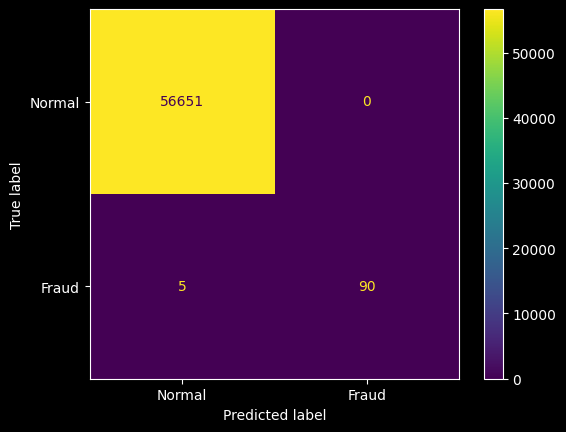

In [51]:
## Confusion matrix for best model
y_pred = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot()